# Inpainting di immagini satellitari

Il progetto riguarda il inpainting (ritocco) di immagini, che consiste nel riempire parti deteriorate o mancanti di un'immagine per ricostruire un'immagine completa.

Il dataset preso in considerazione è il dataset EuroSAT di tensorflow basato su immagini satellitari Sentinel-2, nella versione rgb. Questo comprende 27000 immagini, a risoluzione 64x64.

Una porzione dell'immagine viene mascherata casualmente secondo la procedura descritta di seguito. Il tuo obiettivo è ricostruire l'immagine completa.



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2

Il Downloading e la preparazione del dataset possono richiedere alcuni minuti

In [ ]:
ds_train, ds_info = tfds.load(
    'eurosat/rgb',
    shuffle_files=False,
    #as_supervised=True,  # Returns a tuple (img, label) instead of a dictionary {'image': img, 'label': label}
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteUHKVHU/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_train = ds_train['train']

In [ ]:
ds_train = ds_train.shuffle(1000, seed = 42)

In [ ]:
train_dataset = ds_train.take(20000)
test_dataset = ds_train.skip(20000)

Il generatore fornisce i vostri dati di addestramento. Creiamo una maschera disegnando linee verticali casuali con angoli diversi e con larghezza variabile. La porzione dell'immagine conservata è quella sotto la maschera.

In [ ]:
def generator(dataset,nolines=9):
    while True:  # Start an infinite loop
        for batch in dataset:
            images = batch["image"]
            images_np = images.numpy()

            masks = np.zeros((batch_size, 64, 64))
            for i in range(batch_size):
                for j in range(nolines):
                    start_point = (np.random.randint(0, 64 - 1), 0)
                    end_point = (np.random.randint(0, 64 - 1), 63)
                    thickness = np.random.randint(2, 3)
                    masks[i] = cv2.line(masks[i], start_point, end_point, (1), thickness)

            images_np = images_np / 255.0
            masks = np.stack(((masks),) * 3, axis=-1)

            yield (images_np * masks, images_np)

# Batch the datasets
batch_size = 8
train_dataset_batched = train_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)

# Create generators for the batched datasets
train_generator = generator(train_dataset_batched)
test_generator = generator(test_dataset_batched)

Visualizziamo i dati. Nella prima riga mostriamo le immagini deteriorate, e nella seconda gli originali che devono essere ricostruiti.

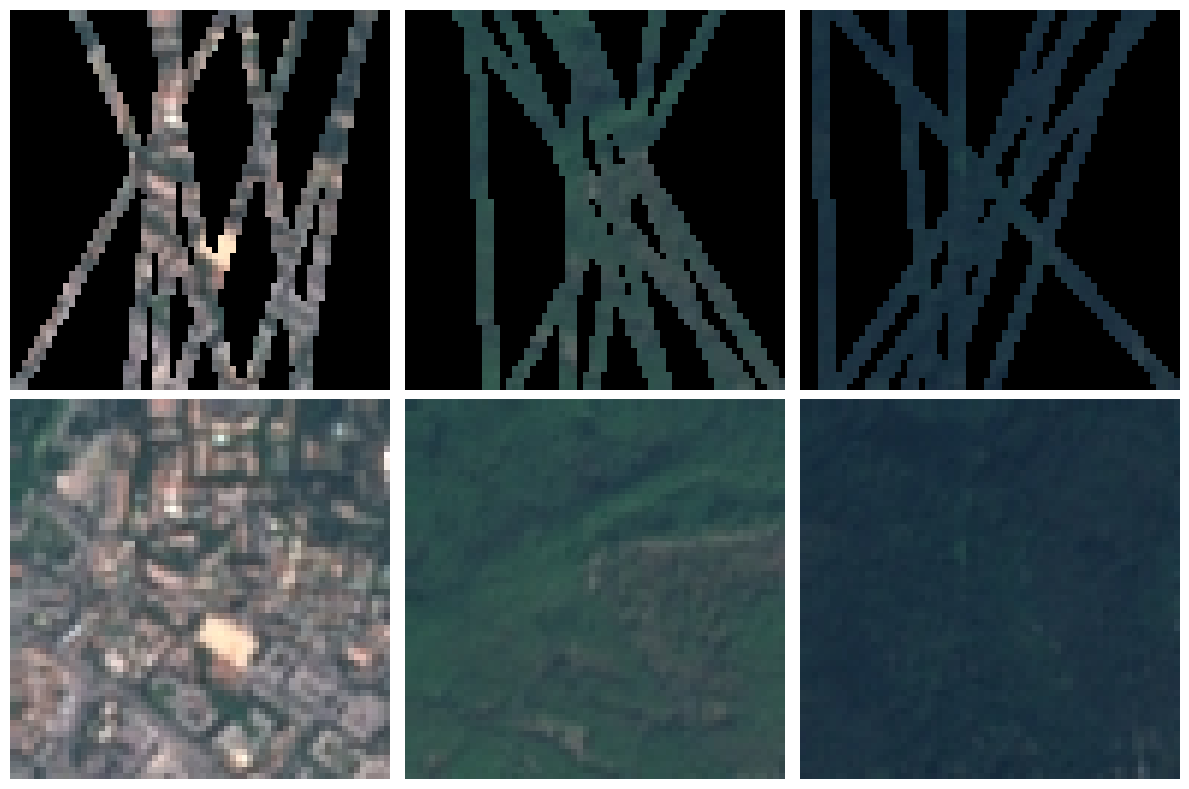

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # Adjust figsize as needed
a,b = next(train_generator)
for i in range(3):
  # Plot image on each subplot
  axes[0,i].imshow(a[i])  # Use cmap='gray' if your images are grayscale
  axes[0,i].axis('off')  # Turn off axis
  axes[1,i].imshow(b[i])  # Use cmap='gray' if your images are grayscale
  axes[1,i].axis('off')  # Turn off axis

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

## Cosa consegnare; metrica di valutazione

La rete deve essere scritta in tensorflow/keras.

Come al solito, dovete consegnare un unico notebook, contenente una traccia completa dell'addestramento della vostra rete. Potete utilizzare qualsiasi funzione di loss durante l'addestramento.

Per valutare la qualità della vostra ricostruzione utilizzate l'mse. Calcolatelo su 10000 immagini generate dal set di test. Ripetete il calcolo precedente 10 volte e fornite il valore medio e la deviazione standard.

## Buon lavoro!

